<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/Correlations_Protein_and_Gene_expression_CPTAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute correlations of protein and gene expression in CPTAC


```
Title:   Correlations of protein and gene expression in CPTAC 
Author:  Boris Aguilar
Created: 05-23-2021
Purpose: Compute correlations between proteomic and gene expression available in the PDC 
Notes: Runs in Google Colab   
```
This notebook uses BigQuery to compute Pearson correlation between protein and gene expression for all the genes in the BigQuery tables of the PDC dataset. We used CCRCC as example; but this can be changed easily for other cancer types.

## Modules

In [1]:
from google.cloud import bigquery
from google.colab import auth
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_gbq

## Google Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Moreover you need to [create a google cloud](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console) project to be able to run BigQuery queries.

In [2]:
auth.authenticate_user()
my_project_id = "" # write your project id here
bqclient = bigquery.Client( my_project_id )

## Retrieve protein expression of CCRCC
The following query will retrieve protein expression and case IDs from CPTAC table `quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current`. Moreover, to label samples as Tumor or Normal samples we join the table with metadata available in the table `aliquot_to_case_mapping_pdc_current` 

In [3]:
prot = '''quant AS (
    SELECT meta.sample_submitter_id, meta.sample_type, quant.case_id, quant.aliquot_id, quant.gene_symbol, 
           CAST(quant.protein_abundance_log2ratio AS FLOAT64) AS protein_abundance_log2ratio 
    FROM `isb-cgc-bq.CPTAC.quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current` as quant
    JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON quant.case_id = meta.case_id
        AND quant.aliquot_id = meta.aliquot_id
        AND meta.sample_type IN ('Primary Tumor','Solid Tissue Normal')
)'''

## Retrieve gene expression of CCRCC
Next we retrieve gene expression data from the table `CPTAC.RNAseq_hg38_gdc_current` which contains RNA-seq data from all tumor types of CPTAC. Moreover we join the data with the metadata table `aliquot_to_case_mapping_pdc_current` to label samples to cancer or normal tissue

In [4]:
gexp = '''gexp AS (
    SELECT DISTINCT meta.sample_submitter_id, meta.sample_type, rnaseq.gene_name , LOG(rnaseq.HTSeq__FPKM + 1) as HTSeq__FPKM   
    FROM `isb-cgc-bq.CPTAC.RNAseq_hg38_gdc_current` as rnaseq
    JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON meta.sample_submitter_id = rnaseq.sample_barcode
)'''

## Compute Pearson correlation
The following query join the protein and gene expression data and compute correlation for each gene and semple type (normal or tumor).

In [5]:
corr = '''correlation AS (
    SELECT quant.gene_symbol, gexp.sample_type, COUNT(*) as n, CORR(protein_abundance_log2ratio,HTSeq__FPKM)  as corr 
    FROM quant JOIN gexp 
        ON quant.sample_submitter_id = gexp.sample_submitter_id
        AND gexp.gene_name = quant.gene_symbol
        AND gexp.sample_type = quant.sample_type
    GROUP BY quant.gene_symbol, gexp.sample_type
)'''

## Compute p-values 

In [6]:
pval = '''SELECT  gene_symbol, sample_type, n, corr,
   `cgc-05-0042.functions.corr_pvalue`(corr, n) as p
FROM correlation
WHERE ABS(corr) <= 1.0'''

## Adjust p-values
The following commands generate the final query which will be sent to Google to retrieve the final data that include the correlation for each gene. The query also includes a function (BHmultipletests) that adjusts the computed p values with the Benjamini-Hochberg method for multipletest correction.

In [7]:
mysql = '''DECLARE Nrows INT64;
CREATE TEMP TABLE PearsonCorrelation AS
WITH {0}, 
{1}, 
{2} 
{3}
;
# Adjust pvalues for multiple tests
SET Nrows = ( SELECT COUNT(*) FROM PearsonCorrelation );
CALL `cgc-05-0042.functions.BHmultipletests`( 'PearsonCorrelation', 'p', Nrows )
'''.format(prot, gexp, corr, pval)

## Run the query to retrieve the analysis 

In [8]:
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False
try:
    query_job = bqclient.query ( mysql, job_config=job_config )
except:
    print ( "  FATAL ERROR: query execution failed " )
mydf = query_job.to_dataframe()

The following command displays the results.

In [9]:
mydf

,gene_symbol,sample_type,n,corr,p,p_adj
0,ANXA13,Primary Tumor,100,0.955971,1.205495e-53,1.767496e-49
1,MYO1B,Primary Tumor,100,0.952969,2.759249e-52,2.022806e-48
2,CES1,Primary Tumor,100,0.949441,8.494844e-51,4.151714e-47
3,PHYHIPL,Primary Tumor,100,0.942866,2.748145e-48,1.007332e-44
4,LGALS3,Primary Tumor,100,0.941492,8.429648e-48,2.471910e-44
...,...,...,...,...,...,...
14657,AHSA1,Solid Tissue Normal,75,0.000278,9.981109e-01,9.983833e-01
14658,CIC,Primary Tumor,100,-0.000204,9.983915e-01,9.985958e-01
14659,SARM1,Solid Tissue Normal,75,0.000200,9.986388e-01,9.987750e-01
14660,C7orf26,Solid Tissue Normal,75,0.000131,9.991117e-01,9.991798e-01


## Histogram of correlations
The results above show the correlation between protein and gene expression for tumors and normal samples. Next we show two histograms of these correlations, one for tumor and the other for normal samples. Moreover we colored the bars by genes that have significant correlations (significant level = 0.01). 

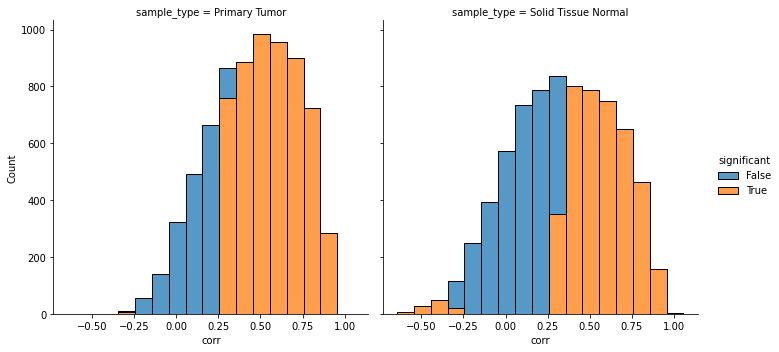

In [10]:
s_level = 0.01 
mydf['significant'] = np.where( mydf['p_adj'] <= s_level, True, False)
sns.displot(data=mydf, x="corr", hue="significant", multiple="stack", binwidth=0.1, col='sample_type')